# Kaden Buckley
# Practice Activity 8.1: kNN & Decision Trees

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [84]:
#!pip install palmerpenguins

from palmerpenguins import load_penguins
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from plotnine import *

In [96]:
penguins = load_penguins()

#Fix concerns about the data
#Get rid of columns with mostly NaN values
good_cols = penguins.isna().sum() < 100
penguins = penguins.loc[:,good_cols]
#Drop other NAs
penguins = penguins.dropna()

penguins['year'] = penguins['year'].astype('object')

penguins
print(penguins.dtypes)

species               object
island                object
bill_length_mm       float64
bill_depth_mm        float64
flipper_length_mm    float64
body_mass_g          float64
sex                   object
year                  object
dtype: object


In [97]:
# Select features and target
X = penguins.drop(columns=['bill_depth_mm'])
y = penguins['bill_depth_mm']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Create identifier for categorical and number columns
catCols = X.select_dtypes(include=['object']).columns
numCols = X.select_dtypes(include=['int64', 'float64']).columns

Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [103]:
#Best Multiple Regression Model from Before
# Preprocessing: OneHotEncoder for categorical variables and StandardScaler for numerical variables
ct = ColumnTransformer(
    transformers=[
        ("dummify", OneHotEncoder(sparse_output = False), ['species', 'sex', 'year']),
        ('Standardize', StandardScaler(), ['bill_length_mm', 'flipper_length_mm', 'body_mass_g']),
    ], remainder = "drop"
).set_output(transform = "pandas")

# Create a pipeline with preprocessing and linear regression
lr_pipeline = Pipeline(
    [("preprocessing", ct),
     ("linear_regression", LinearRegression())]
    )

# Train the pipeline
lr_pipeline.fit(X_train, y_train)

#Cross-Validation
scores = cross_val_score(lr_pipeline, X_test, y_test, cv = 5, scoring = 'neg_mean_squared_error')
linear_mse = -scores.mean()
print(f"MSE of Linear Model: {linear_mse}")

MSE of Linear Model: 0.9058597963316034


In [104]:
#kNN Model 1 (K=3)
# Preprocessing: OneHotEncoder for categorical variables and StandardScaler for numerical variables
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ]
)

# Create a pipeline with preprocessing and logistic regression
knn_pipeline_1 = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('classifier', KNeighborsRegressor(n_neighbors=3))
    ]
)

# Train the pipeline
knn_pipeline_1.fit(X, y)

#Get MSE using Cross-Validation
scores = cross_val_score(knn_pipeline_1, X_test, y_test, cv = 5, scoring = 'neg_mean_squared_error')
knn1_mse = -scores.mean()
print(f"MSE of kNN 1: {knn1_mse}")

MSE of kNN 1: 1.0050825163398702


In [105]:
#kNN Model 2 (K=10)
# Preprocessing: OneHotEncoder for categorical variables and StandardScaler for numerical variables
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ]
)

# Create a pipeline with preprocessing and logistic regression
knn_pipeline_2 = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('classifier', KNeighborsRegressor(n_neighbors=10))
    ]
)

# Train the pipeline
knn_pipeline_2.fit(X, y)

#Get MSE using Cross-Validation
scores = cross_val_score(knn_pipeline_2, X_test, y_test, cv = 5, scoring = 'neg_mean_squared_error')
knn2_mse = -scores.mean()
print(f"MSE of kNN 2: {knn2_mse}")

MSE of kNN 2: 0.9586997794117653


In [106]:
#Decision Tree
# Preprocessing: OneHotEncoder for categorical variables and StandardScaler for numerical variables
ct = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numCols),
        ('cat', OneHotEncoder(), catCols)
    ]
)

# Create a pipeline with preprocessing and logistic regression
dt_pipeline = Pipeline(
    steps=[
        ('preprocessor', ct),
        ('classifier', DecisionTreeRegressor(min_samples_leaf=15))
    ]
)

# Train the pipeline
dt_pipeline.fit(X_train, y_train)

#Get MSE using Cross-Validation
scores = cross_val_score(dt_pipeline, X_test, y_test, cv = 5, scoring = 'neg_mean_squared_error')
dt_mse = -scores.mean()
print(f"MSE of Decision Tree: {dt_mse}")

MSE of Decision Tree: 1.2484720257335313


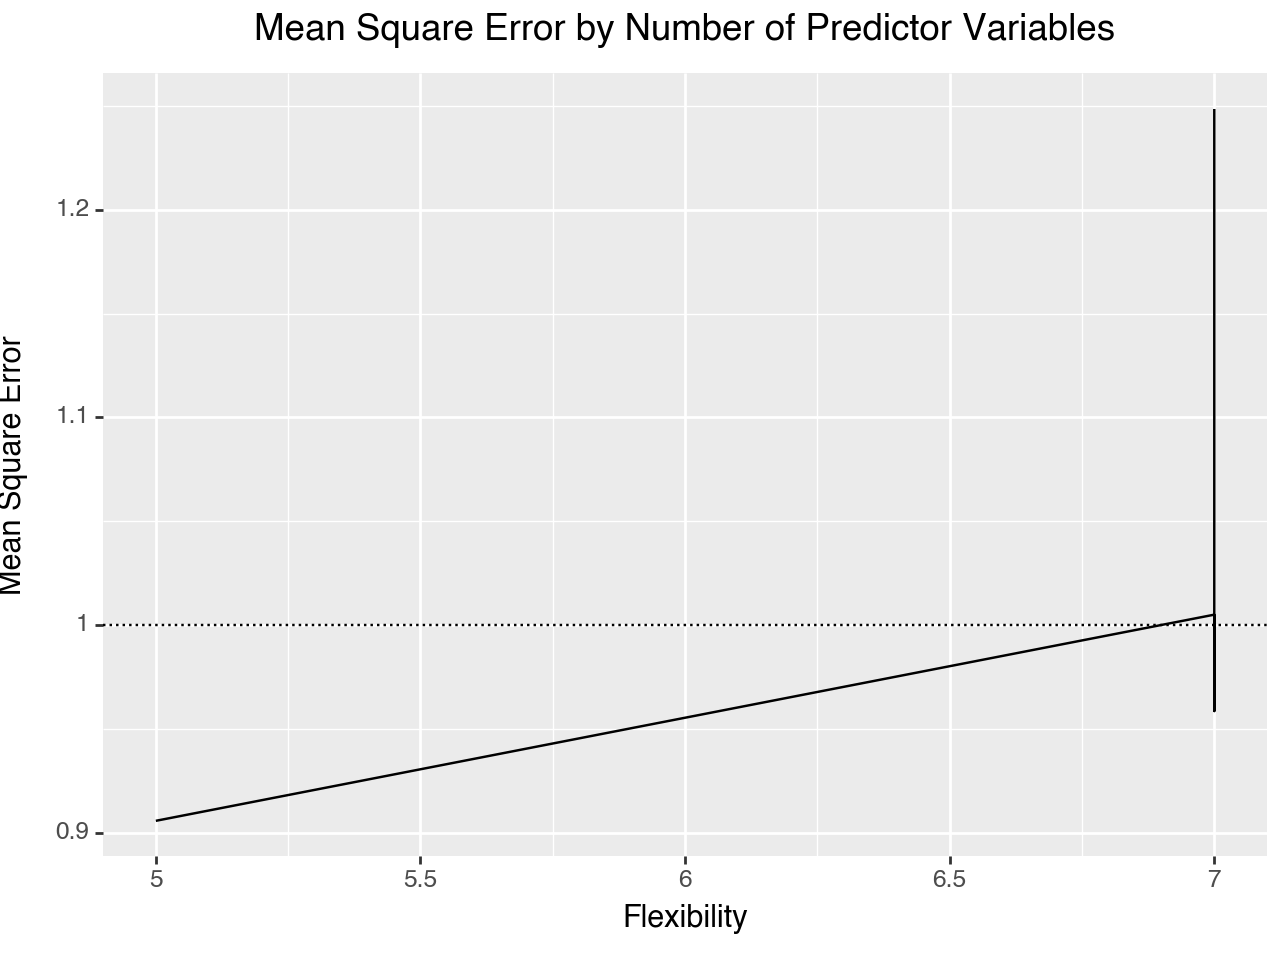

In [107]:
#Create a plot like the right plot of Fig 1. in our Model Validation chapter
#Create new data frame to use to plot
mse_df = pd.DataFrame({
    'Predictors': [5, 7, 7, 7],
    'Mean_Square_Error': [linear_mse, knn1_mse, knn2_mse, dt_mse]
})

#Make the plot
mse_plot = (ggplot(mse_df, aes('Predictors', 'Mean_Square_Error', group =1))
  + geom_line()
  + geom_hline(aes(yintercept = 1), linetype = "dotted")
  + labs(x = "Flexibility", y = "Mean Square Error", title = "Mean Square Error by Number of Predictor Variables")
  + theme(title=element_text(hjust=0.5))
            )

print(mse_plot)